# Code to research by Justin Snelders, 2025.

Data and paper can be found on GitHub: [GitHub link](https://github.com/JustSnelders/XAD-with-DIFF-and-SHAP)

## Importing

Here, all the necessary libraries for the analysis are imported.

In [192]:
# Standard Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Machine Learning libraries
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# SHAP
import shap

## Loading the data

The dataset is a Kaggle dataset consisting of financial transaction data, curated by Vala Khorasani. The link to the data can be found here: [Kaggle link](https://www.kaggle.com/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection/data)

In [193]:
# Load and display the dataset
df = pd.read_csv("data.csv")
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [194]:
# Check that the data has no missing values (result should be int64(0))
df.isnull().any(axis=1).sum()

np.int64(0)

## Preprocessing the data

First, the data is preprocessed.  this research is mainly focused on
detecting potentially fraudulent transactions based on statistically relevant data inherently linked to a single transaction. Therefore, attributes related to identification,
location and time are discarded.



In [195]:
# Drop identifier and location columns
X = df.drop(columns=["TransactionID", "AccountID", "Location", "DeviceID", "IP Address", "MerchantID", "CustomerAge", "CustomerOccupation"])

# Drop time-related columns
X = X.drop(columns=["TransactionDate", "PreviousTransactionDate"])
X

,TransactionAmount,TransactionType,Channel,TransactionDuration,LoginAttempts,AccountBalance
0,14.09,Debit,ATM,81,1,5112.21
1,376.24,Debit,ATM,141,1,13758.91
2,126.29,Debit,Online,56,1,1122.35
3,184.50,Debit,Online,25,1,8569.06
4,13.45,Credit,Online,198,1,7429.40
...,...,...,...,...,...,...
2507,856.21,Credit,Branch,109,1,12690.79
2508,251.54,Debit,Branch,177,1,254.75
2509,28.63,Debit,Branch,146,1,3382.91
2510,185.97,Debit,Online,19,1,1776.91


Next, the data is standardized. Numerical columns are scaled using the StandardScaler library. Categorical columns are one-hot encoded. To efficiently make this separation, a ColumnTransformer is used.

In [196]:
# Specify categorical and numerical columns
categorical_cols = ["TransactionType", "Channel"]
numerical_cols = X.drop(columns=categorical_cols).columns.tolist()

# Standardize the data
transformer = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
])
X_scaled = transformer.fit_transform(X)

## Predicting Anomalies using Isolation Forest

The Isolation Forest model is fitted on the scaled data. The model makes a binary prediction, where -1 indicates potential fraud and 1 indicates a normal transaction. Additionally, the model returns an Anomaly Score. The higher the score, the more likely that observation is to be an anomaly and thus a fraudulent transaction.

In [197]:
# Initialize and train IF model
clf = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
clf.fit(X_scaled)

IsolationForest(contamination=0.05, random_state=42)

In [198]:
# Predict anomalies
df['AnomalyScore'] = clf.decision_function(X_scaled)
df['IsAnomaly'] = clf.predict(X_scaled)
df

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,AnomalyScore,IsAnomaly
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08,0.157457,1
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35,0.090147,1
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04,0.168795,1
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06,0.137239,1
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39,0.084306,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,TX002508,AC00297,856.21,2023-04-26 17:09:36,Credit,Colorado Springs,D000625,21.157.41.17,M072,Branch,33,Doctor,109,1,12690.79,2024-11-04 08:11:29,-0.008659,-1
2508,TX002509,AC00322,251.54,2023-03-22 17:36:48,Debit,Tucson,D000410,49.174.157.140,M029,Branch,48,Doctor,177,1,254.75,2024-11-04 08:11:42,0.147875,1
2509,TX002510,AC00095,28.63,2023-08-21 17:08:50,Debit,San Diego,D000095,58.1.27.124,M087,Branch,56,Retired,146,1,3382.91,2024-11-04 08:08:39,0.168663,1
2510,TX002511,AC00118,185.97,2023-02-24 16:24:46,Debit,Denver,D000634,21.190.11.223,M041,Online,23,Student,19,1,1776.91,2024-11-04 08:12:22,0.149839,1


In [199]:
# Show number of found anomalies
potential_frauds = df[df['IsAnomaly'] == -1]
print(f"Number of potential frauds detected: {len(potential_frauds)}")

Number of potential frauds detected: 126


As IF indicates anomalies in unlabeled data, there are no validation metrics that indicate some representation of accuracy. However, different attributes can be plotted against each other and observed with domain knowledge.

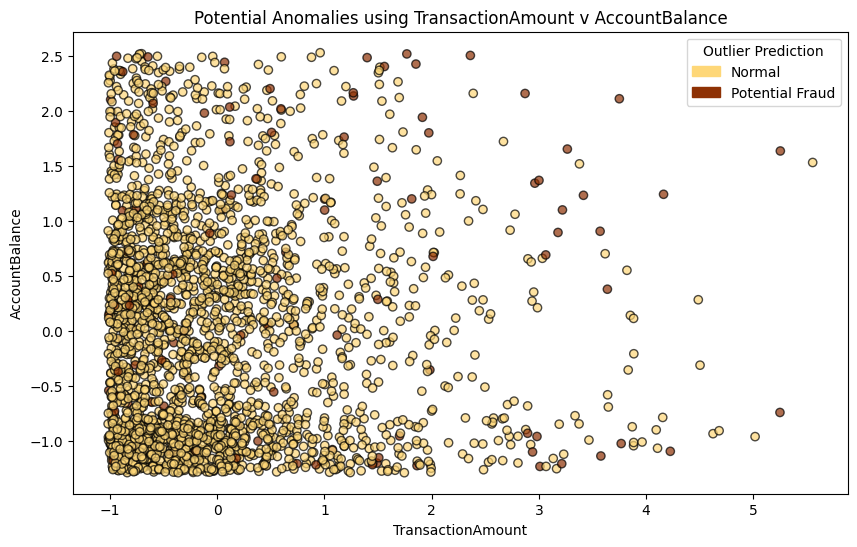

In [200]:
# Define color mapping to indicate outliers in plot
cmap = plt.get_cmap('YlOrBr')
colors = np.array([cmap(0.9) if anomaly == -1 else cmap(0.3) for anomaly in df['IsAnomaly']])

# Example plot of 2 variables against each other: TransactionAmount v AccountBalance
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_scaled[:, 0],  # TransactionAmount
    X_scaled[:, 3],  # AccountBalance
    c=colors,
    alpha=0.7,
    edgecolors='k',
    label='Data Points'
)

normal_patch = mpatches.Patch(color=cmap(0.3), label='Normal')
fraud_patch = mpatches.Patch(color=cmap(0.9), label='Potential Fraud')
plt.legend(handles=[normal_patch, fraud_patch], title='Outlier Prediction')

plt.title('Potential Anomalies using TransactionAmount v AccountBalance')
plt.xlabel("TransactionAmount")
plt.ylabel("AccountBalance")

plt.show()

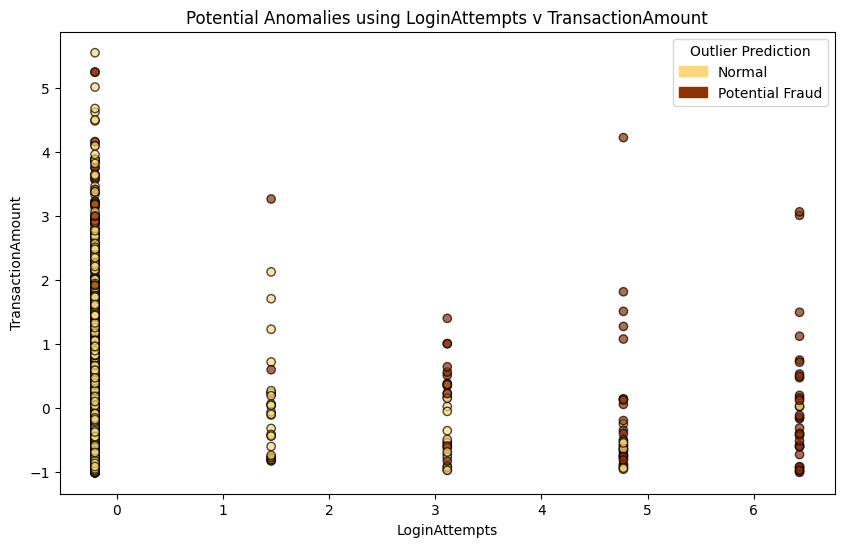

In [201]:
# Define color mapping to indicate outliers in plot
cmap = plt.get_cmap('YlOrBr')
colors = np.array([cmap(0.9) if anomaly == -1 else cmap(0.3) for anomaly in df['IsAnomaly']])

# Example plot of 2 variables against each other: LoginAttempts v TransactionAmount
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_scaled[:, 2],  # LoginAttempts
    X_scaled[:, 0],  # TransactionAmount
    c=colors,
    alpha=0.7,
    edgecolors='k',
    label='Data Points'
)

normal_patch = mpatches.Patch(color=cmap(0.3), label='Normal')
fraud_patch = mpatches.Patch(color=cmap(0.9), label='Potential Fraud')
plt.legend(handles=[normal_patch, fraud_patch], title='Outlier Prediction')

plt.title('Potential Anomalies using LoginAttempts v TransactionAmount')
plt.xlabel("LoginAttempts")
plt.ylabel("TransactionAmount")

plt.show()

## Need for Explanation Methods

Bank fraud transactions do not have a label "fraudulent" on them. As shown in the previous section, plotting two of the involved variables against each other only gives a limited explanation (sometimes, even no explanation) for the prediction. For customer trust, it is crucial to give insights into the reasons behind the predictions. They have a right to know why a model labels some transactions as fraudulent, and what they can do to prevent this. Explanation methods can additionally help developers to identify faults or biases in the model, leading to a more accurate and trustworthy model.

## Depth-based Isolation Forest Feature Importance (DIFFI)

DIFFI is a model-specific explanation method for computing feature importances in isolation forest models. The method was created by Carletti et al. in their 2020 paper "*Interpretable Anomaly Detection with DIFFI*". The function below implements the pseudocode provided in the original paper. The Global Feature Importance (GFI) for the bank transaction fraud is computed using this function. The results are plotted below.

In [202]:
def compute_diffi(clf, X_scaled, feature_names):
    """
    Compute DIFFI (Depth-based Isolation Forest Feature Importance) scores

    Parameters:
        clf           : Isolation Forest model (sklearn)
        X_scaled      : preprocessed input data (NumPy array)
        feature_names : list of feature names corresponding to X_scaled

    Returns:
        A DataFrame with features and their DIFFI scores, sorted by importance
    """

    n_features = X_scaled.shape[1]
    n_samples = X_scaled.shape[0]

    # Initialize counter and importance variables
    CI = np.zeros(n_features)  # Count of inlier splits
    II = np.zeros(n_features)  # Importance for inliers
    CO = np.zeros(n_features)  # Count of outlier splits
    IO = np.zeros(n_features)  # Importance for outliers

    # Loop over each tree
    predictions = clf.predict(X_scaled)
    is_inlier = predictions == 1
    is_outlier = predictions == -1

    for estimator in clf.estimators_:
        tree = estimator.tree_
        node_indicator = estimator.decision_path(X_scaled)

        # Define IICs by path lengths
        path_lengths = np.asarray([
            node_indicator.indptr[i+1] - node_indicator.indptr[i]
            for i in range(n_samples)
        ])
        IIC = 1.0 / path_lengths

        Lambda_I = np.zeros(n_samples)
        Lambda_O = np.zeros(n_samples)
        Lambda_I[is_inlier] = IIC[is_inlier]
        Lambda_O[is_outlier] = IIC[is_outlier]

        # Update counters for each sample's path
        for i in range(n_samples):
            x = X_scaled[i:i+1]
            path = node_indicator.indices[node_indicator.indptr[i]:node_indicator.indptr[i+1]]
            for node_id in path:
                f = tree.feature[node_id]
                if f == -2:
                    continue  # skip leaf node
                if is_inlier[i]:
                    CI[f] += 1
                    II[f] += Lambda_I[i]
                elif is_outlier[i]:
                    CO[f] += 1
                    IO[f] += Lambda_O[i]

    # Compute Global Feature Importance (GFI)
    epsilon = 1e-9
    GFI = (IO / (CO + epsilon)) / (II / (CI + epsilon))

    # Output DataFrame
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'DIFFI': GFI
    }).sort_values(by='DIFFI', ascending=False)

    return fi_df

In [203]:
# Get feature names from the transformer
num_features = transformer.named_transformers_["num"].get_feature_names_out(numerical_cols)
cat_features = transformer.named_transformers_["cat"].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([num_features, cat_features])
all_feature_names

array(['TransactionAmount', 'TransactionDuration', 'LoginAttempts',
       'AccountBalance', 'TransactionType_Credit',
       'TransactionType_Debit', 'Channel_ATM', 'Channel_Branch',
       'Channel_Online'], dtype=object)

In [204]:
diffi_scores = compute_diffi(clf, X_scaled, all_feature_names)
diffi_scores

,feature,DIFFI
2,LoginAttempts,1.364519
4,TransactionType_Credit,1.268867
6,Channel_ATM,1.237340
5,TransactionType_Debit,1.224458
8,Channel_Online,1.214374
7,Channel_Branch,1.208154
0,TransactionAmount,1.176137
3,AccountBalance,1.162955
1,TransactionDuration,1.161047


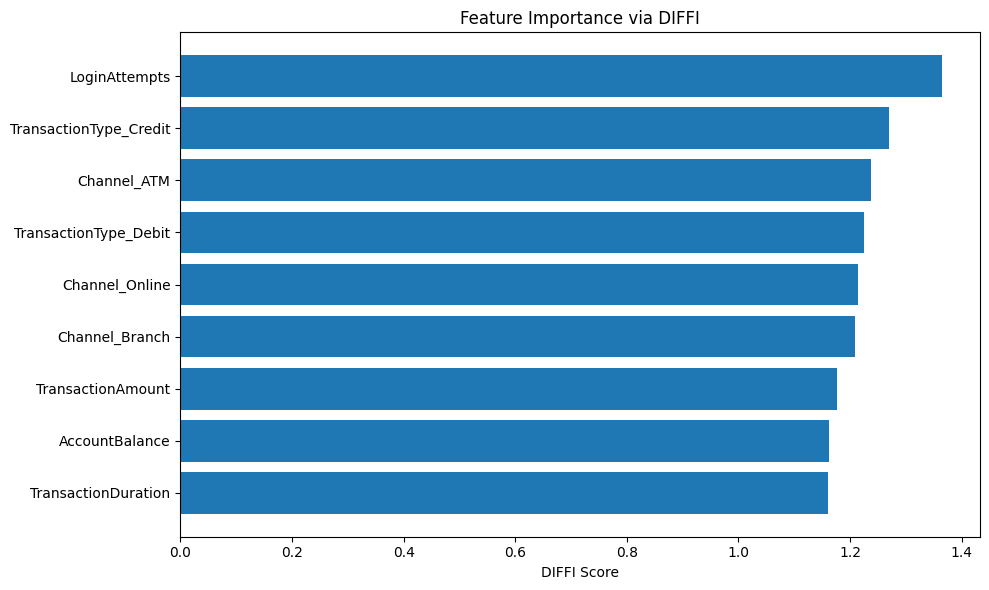

In [205]:
plt.figure(figsize=(10, 6))
plt.barh(diffi_scores["feature"], diffi_scores["DIFFI"])
plt.xlabel("DIFFI Score")
plt.title("Feature Importance via DIFFI")
plt.gca().invert_yaxis()  # Most important feature at the top
plt.tight_layout()
plt.show()

## SHapley Additive exPlanations (SHAP)
SHAP is a model-agnostic explanation method providing both global and local explanations for machine learning models. SHAP values indicate how much each feature contributes to the model prediction. Below, the SHAP explanation is implemented.

In [206]:
# For SHAP, the scaled data needs to be converted to a Pandas DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=all_feature_names)
df_scaled

,TransactionAmount,TransactionDuration,LoginAttempts,AccountBalance,TransactionType_Credit,TransactionType_Debit,Channel_ATM,Channel_Branch,Channel_Online
0,-0.971275,-0.552443,-0.206794,-0.000537,0.0,1.0,1.0,0.0,0.0
1,0.269440,0.305314,-0.206794,2.216472,0.0,1.0,1.0,0.0,0.0
2,-0.586882,-0.909842,-0.206794,-1.023534,0.0,1.0,0.0,0.0,1.0
3,-0.387456,-1.353017,-0.206794,0.885797,0.0,1.0,0.0,0.0,1.0
4,-0.973468,1.120184,-0.206794,0.593589,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2507,1.913802,-0.152156,-0.206794,1.942606,1.0,0.0,0.0,1.0,0.0
2508,-0.157779,0.819969,-0.206794,-1.245986,0.0,1.0,0.0,1.0,0.0
2509,-0.921462,0.376794,-0.206794,-0.443928,0.0,1.0,0.0,1.0,0.0
2510,-0.382420,-1.438793,-0.206794,-0.855705,0.0,1.0,0.0,0.0,1.0


In [207]:
# Generate SHAP explanations for entire dataset
explainer = shap.KernelExplainer(clf.decision_function, shap.kmeans(df_scaled, 10))
nb_points_explain = df_scaled.shape[0]
shap_values = explainer(df_scaled.iloc[0:nb_points_explain, :])

  0%|          | 0/2512 [00:00<?, ?it/s]

In [208]:
# Print the average predicted output (should be higher than 0, majority of transactions is not fraudulent)
ref = explainer.expected_value
print("Average predicted output: ",ref)

Average predicted output:  0.15637335792582568


After generating the explanations, the results can be visualized using several plots. To visualize the global explanations, the following code blocks generate a beeswarm plot and a heatmap.

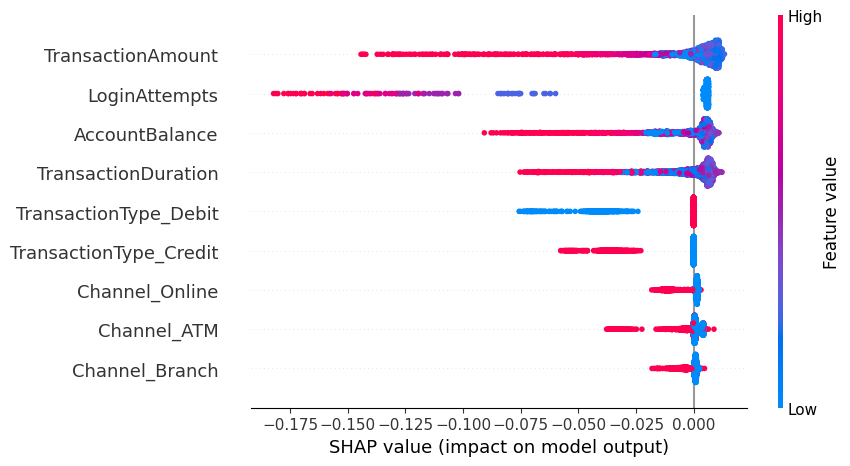

In [209]:
# Plot a SHAP Beeswarm (aka summary plot)
shap.plots.beeswarm(shap_values)

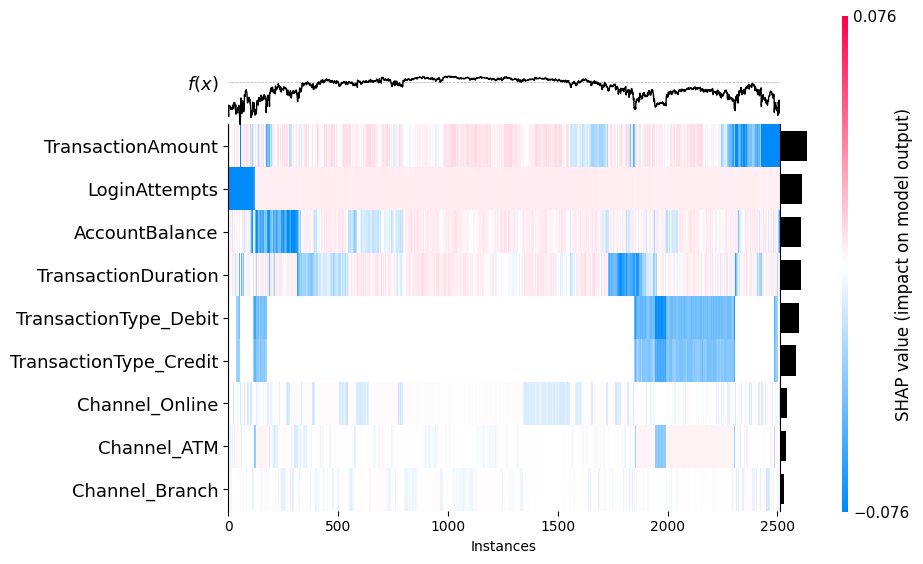

<Axes: xlabel='Instances'>

In [191]:
# Plot a SHAP Heatmap
shap.plots.heatmap(shap_values)

SHAP additionally provides tooling for local explanations of individual instances. Below are two waterfall plots for transactions that were labeled as possibly fraudulent by the IF model.

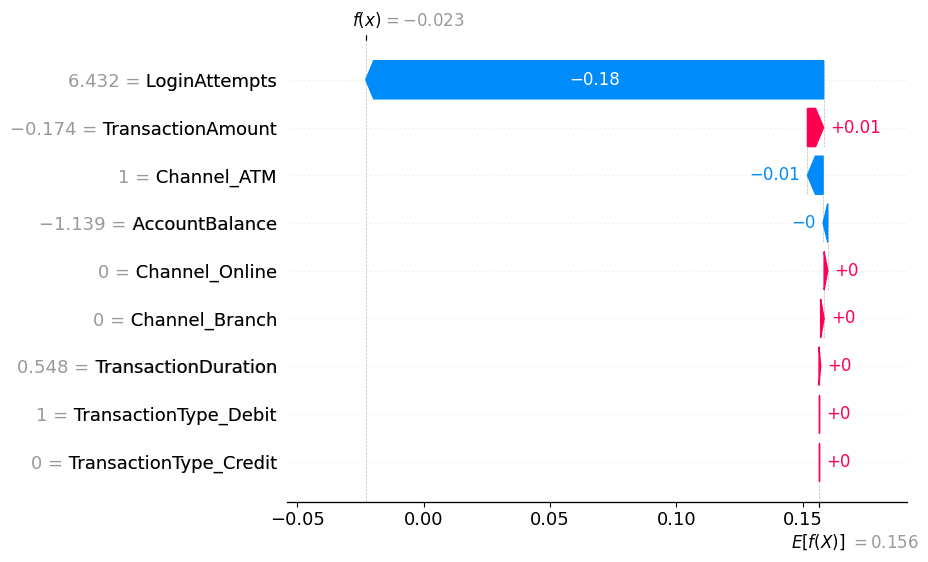

In [210]:
# Waterfall plot for observation i = 26
i = 26
shap.plots.waterfall(shap_values[i])

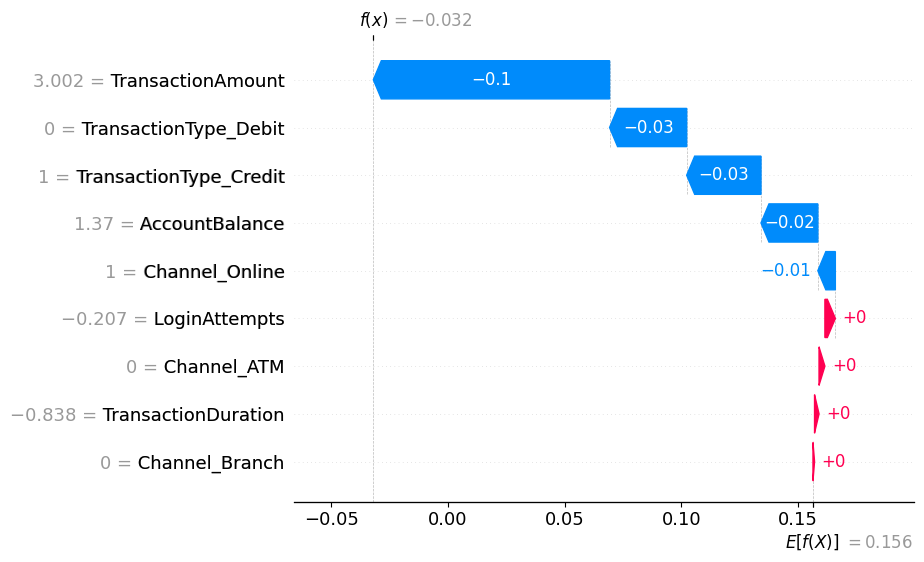

In [211]:
# Waterfall plot for observation i = 2380
i = 2380
shap.plots.waterfall(shap_values[i])